In [44]:
# from trainModel import *
import torch
from torchData import duneADCdata
from torch.utils.data import random_split
import matplotlib.pyplot as plt
# from SparseCNN import SparseNet
from torchvision import datasets, transforms
from torchDataSparse import duneADCdata, ToTensor
# import sparseconvnet as scn
from scipy.sparse import coo_matrix
# torch.manual_seed(1516989)

In [45]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
from skimage import io
import numpy as np
from scipy.sparse import coo_matrix
import torch.nn.functional as F
import sys

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, target = sample['input'], sample['target']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        # image = image.transpose((2, 0, 1))
        return {'input': torch.from_numpy(image),
                'target': target}  # torch.from_numpy(target)}


class myData(Dataset):
    def __init__(self, csv_file, root_dir, transform=None,batch_size=1):
        self.maxSize = 200
        self.data = pd.read_csv(csv_file)
        self.coords = []
        self.features = []
        self.targets = []
        self.root_dir = root_dir
        self.transform = transform
        toolbar_width = len(self.data)
        sys.stdout.write("Loading dataset:\n")
        sys.stdout.flush()

        for i in range(len(self.data)):
            img_name = os.path.join(self.root_dir, self.data.iloc[i, 0])
            img = io.imread(img_name)
            img = coo_matrix(img)
            features = torch.FloatTensor(img.data)
#             features = img.data
            if features.size(0) <= self.maxSize and features.size(0) != 0:
                coordsx = img.row
                coordsy = img.col
                coords = np.dstack((coordsx,coordsy,np.zeros(features.size(0))))
                coords = torch.IntTensor(coords)
                pad1 = (0,self.maxSize-features.size(0))
                pad2 = (0,0,0,self.maxSize-features.size(0))
                coords = F.pad(coords,pad2,'constant',0)
                features = np.pad(features,pad1,'constant',constant_values=0)
                target = self.data.iloc[i, 1]
                self.coords.append(coords)
                self.features.append(features)
                self.targets.append(target)

            sys.stdout.write("{}%\r".format(int(i*100/(len(self.data)))))
            sys.stdout.flush()
#         self.coords = torch.cat(self.coords,0)
#         self.features  = torch.FloatTensor(self.features)
        print(self.targets)
#         self.targets  = torch.FloatTensor(self.targets)


    def __len__(self):
        return len(self.targets)#self.targets.size(0)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {"input": (self.coords[idx],self.features[idx]), "target": self.targets[idx]}
        
        if self.transform:
            sample = self.transform(sample)
        return sample
    

In [58]:
import torch
import torch.nn as nn
import sparseconvnet as scn
import torch.nn.functional as F

# from data import get_iterators

# two-dimensional SparseConvNet
class SparseNet(nn.Module):
    def __init__(self):
#         nn.Module.__init__(self)
#         self.sparseModel = scn.Sequential(
#             scn.SubmanifoldConvolution(2, 2000, 8, 3, False),
#             scn.MaxPooling(2, 3, 2),
#             scn.SparseResNet(2, 8, [
#                         ['b', 8, 2, 1],
#                         ['b', 16, 2, 2],
#                         ['b', 24, 2, 2],
#                         ['b', 32, 2, 2]]),
#             scn.Convolution(2, 32, 64, 5, 1, False),
#             scn.BatchNormReLU(64),
#             scn.SparseToDense(2, 64))
#         self.spatial_size= self.sparseModel.input_spatial_size(torch.LongTensor([1, 1]))
#         self.inputLayer = scn.InputLayer(2,self.spatial_size,2)
#         self.linear = nn.Linear(64, 2)
        nn.Module.__init__(self)
        self.sparseModel = scn.Sequential(
            scn.SubmanifoldConvolution(2, 200, 8, 3, False),
            scn.MaxPooling(2, 3, 2),
            scn.SubmanifoldConvolution(2, 200, 16, 3, False),
            scn.MaxPooling(2, 3, 2),


#             scn.SparseResNet(2, 8, [
#                         ['b', 8, 2, 1],
#                         ['b', 16, 2, 2],
#                         ['b', 24, 2, 2],
#                         ['b', 32, 2, 2]]),
#             scn.Convolution(2, 16, 32, 5, 1, False),
# #             scn.BatchNormReLU(32),
#             scn.MaxPooling(2, 3, 2),

            scn.SparseToDense(2, 8))
        self.spatial_size= self.sparseModel.input_spatial_size(torch.LongTensor([1, 1]))
#         print(self.spatial_size)
#         self.spatial_size=1500#torch.IntTensor(1500)
#         print(self.spatial_size)
        self.inputLayer = scn.InputLayer(dimension = 2,spatial_size = self.spatial_size)
#         self.linear = nn.Linear(16, 8)

        self.linear = nn.Linear(8, 2)

    def forward(self, x):
        x = self.inputLayer(x)
        x = self.sparseModel(x)
        x = x.view(-1, 8)
        x = F.softmax(self.linear(x))
        return x


In [47]:
class VGGNet(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.sparseModel = scn.Sequential(
        scn.SubmanifoldConvolution(2, 200, 8, 3, False),
          scn.SparseVggNet(2, 8, [
#             ['C', 8, ], ['C', 8], 'MP',
            ['C', 16], ['C', 16], 'MP',
            ['C', 16, 8], ['C', 16, 8], 'MP',
            ['C', 24, 8], ['C', 24, 8], 'MP']),
          scn.Convolution(2, 32, 64, 5, 1, False),
          scn.BatchNormReLU(64),
          scn.SparseToDense(2, 64))
        self.spatial_size= self.sparseModel.input_spatial_size(torch.LongTensor([1, 1]))
        self.inputLayer = scn.InputLayer(2,self.spatial_size,2)
        self.linear = nn.Linear(64, 2)

    def forward(self, x):
        x = self.inputLayer(x)
        x = self.sparseModel(x)
        x = x.view(-1, 64)
        x = F.softmax(self.linear(x))
        return x


In [48]:
import torch
# from torchData import duneADCdata, ToTensor

import sys
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from torchvision import datasets, transforms
import matplotlib.pyplot as plt
# from simpleCNN import Net


def train(net, trainloader, optimizer, batch_size=32, n_epochs=10, model_fname="model.pth",learning_rate = 0.001):
    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.0)
#     optimizer = optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999), eps=1e-8,
#                  weight_decay=0, amsgrad=False)
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        toolbar_width = len(trainloader)
        running_loss = 0.0
        sys.stdout.write("Epoch {}/{}:\n".format(epoch+1,n_epochs))
        sys.stdout.write("[%s]" % (" " * toolbar_width))
        sys.stdout.flush()
        sys.stdout.write("\b" * (toolbar_width+1)) # return to start of line, after '['
        
        for i, data in enumerate(trainloader, 0):
#             sys.stdout.flush()

           
            inputs = data['input']
#             print(inputs)
#             print(inputs[0].size())
#             print(inputs[1].size())

#             if inputs[0].size(0) == batch_size:
            labels = data['target']
#             print(labels.size())
            optimizer.zero_grad()
            outputs = net(inputs)
#             print(outputs.size())
            print(outputs)
#             print(labels)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            losses.append(loss.item())

    #             if i % 2000 == 1999:    # print every 2000 mini-batches
    #                 print('[%d, %5d] loss: %.3f' %
    #                       (epoch + 1, i + 1, running_loss))
    #                 losses.append(running_loss)
    #                 _, predicted = torch.max(outputs.data, 1)
    #                 print("Predicted: {}\nTarget: {}".format(predicted[j],labels[j]) for j in range(4))
    #                 #             print('Predicted: ', ' '.join('%5s' % predicted[j]
    #                 #                               for j in range(8)))
    #                 print("%: {}".format(outputs.data))
    #                 running_loss = 0.0
    #             sys.stdout.write("{}".format(loss.item()))
    #             sys.stdout.flush()
    #             sys.stdout.write("-\r")
    #             sys.stdout.flush()
            
        sys.stdout.write("]\n")
#         print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss/batch_size))
        running_loss = 0
    print('Finished Training')
    torch.save(net.state_dict(), "./model/"+model_fname)
    return (net,losses)


In [59]:
net = SparseNet()
# net = VGGNet()

# batch_size=32

In [60]:
transform = transforms.Compose([ToTensor()])
batch_size = 1#broken, use 1
# data = duneADCdata("seconddata.csv", "./",batch_size=batch_size)#, transform=transform)
# data = myData("babydata.csv", "./")
# data = myData("bigdata.csv", "./",batch_size=batch_size)#, transform=transform)
data = myData("bigdata_new.csv", "./",batch_size=batch_size)#, transform=transform)
print(data[0])

Loading dataset:


KeyboardInterrupt: 

In [61]:
# batch_size = 31#broken, use 1
# data.targets[0:10] = [1 for _ in range(10)]
n_epochs=10
# batch_size = 4
classes = ["radio","SNB"]
lengths = [int(len(data)*0.8),int(len(data))-int(len(data)*0.8)]
trainData, testData= random_split(data,lengths)
trainLoader = DataLoader(trainData, batch_size=batch_size)#, shuffle=True)
testLoader = DataLoader(testData, batch_size=1)#, shuffle=True)
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.8,weight_decay=0.0000)

# batch_size = 1
print(data[0]['input'])

(tensor([[[484, 633,   0],
         [564, 584,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         [ 

In [62]:
net,losses = train(net, trainLoader,optimizer,n_epochs=n_epochs,batch_size=batch_size,learning_rate=0.001)

Epoch 1/10:


[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], grad_fn=<SoftmaxBackward>)
tensor([[0.3997, 0.6003]], g

AssertionError: (200, 16, SparseConvNetTensor<<features=tensor([[21.6180,  0.0000, 23.5793, 22.5136, 15.8825,  0.0000,  0.0000,  0.0000]],
       grad_fn=<MaxPoolingFunctionBackward>),features.shape=torch.Size([1, 8]),batch_locations=tensor([[2, 1, 0]]),batch_locations.shape=torch.Size([1, 3]),spatial size=tensor([3, 3])>>)

In [38]:
# data[0]
it = {'train':trainLoader,'val':testLoader}
scn.ClassificationTrainValidate(
    net, it,
    {'n_epochs': 1,
     'initial_lr': 0.001,
     'lr_decay': 0.001,
     'weight_decay': 0.5,
     'use_cuda': torch.cuda.is_available(),
     'check_point': False, })


{'n_epochs': 1, 'initial_lr': 0.001, 'lr_decay': 0.001, 'weight_decay': 0.5, 'use_cuda': False, 'check_point': False, 'momentum': 0.9, 'test_reps': 1, 'epoch': 1}
#parameters 110871


KeyboardInterrupt: 

In [30]:
net.load_state_dict(torch.load("./model/model.pth"))


<All keys matched successfully>

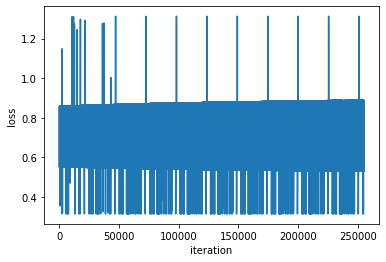

In [56]:
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

[0.67193628 0.67832911 0.68504253 0.67735116 0.68027599 0.67796504
 0.67296447 0.6770896  0.67453028 0.66863647 0.67426675 0.67831174
 0.67389737 0.67246212 0.67164853 0.67785278 0.68515897 0.67714713
 0.68017451 0.67741122 0.67233594 0.67698906 0.67384156 0.66815459
 0.67409746 0.67825689 0.67372472 0.67221642 0.6714335  0.67774336
 0.68527555 0.67708226 0.68017558 0.67703745 0.67147028 0.67691525
 0.6736952  0.66753027 0.67396301 0.67821212 0.67358682 0.67205749
 0.671258   0.67770699 0.68538888 0.67703918 0.68018772 0.6767831
 0.67130054 0.67686141 0.67358043 0.66729695 0.67385553 0.67818272
 0.67347589 0.67192834 0.67111378 0.67768636 0.68549684 0.67701035
 0.68020687 0.67672552 0.6711669  0.67682229 0.67348777 0.66710758
 0.67376883 0.67816437 0.67338589 0.67182224 0.67099427 0.67767533
 0.68559836 0.67699173 0.68023025 0.6766908  0.67105682 0.67679412
 0.67341244 0.66694816 0.6736985  0.67815399 0.6733124  0.67173447
 0.67089459 0.67767099 0.6856929  0.6769805  0.68025587 0.67666

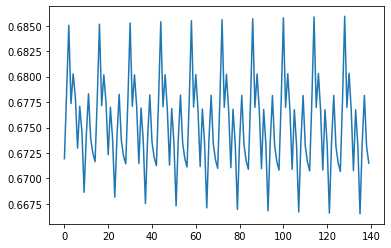

In [57]:
avg_losses = np.mean(np.reshape(np.array(losses),(140,-1)),axis=1)
print(avg_losses)
plt.plot(avg_losses)
plt.show()

In [ ]:
dataiter = iter(testLoader)
true = []
predict = []
for d in dataiter:
    images = d['input']
    labels = d['target']
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
    predict.append(predicted)
    true.append(labels)

In [ ]:
correct = 0
total = 0
snb = 0
radio = 0
with torch.no_grad():
    for d in testLoader:
        images = d ['input']
        labels = d ['target']
        outputs = net(images)
        print(outputs.data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        snb += (predicted == 1).sum().item()
        radio += (predicted == 0).sum().item()

        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("SNB: {}".format(snb))
print("Radio: {}".format(radio))

In [ ]:
from sklearn.metrics import confusion_matrix
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testLoader:
        images = data['input']
        labels = data['target']
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(2):
            label = classes[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(cm, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()